In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as F
from  pyspark.sql.functions import col

spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

# steam_reviews_filepath = "../data/cleaned_steam_reviews/game_id={70,240,420,620}"
steam_reviews_filepath = "../data/cleaned_steam_reviews"
steam_games_filepath = "../data/cleaned_steam_games"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/24 16:27:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/24 16:27:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
steam_reviews = spark.read.parquet(steam_reviews_filepath)

In [3]:
steam_games = spark.read.parquet(steam_games_filepath)

steam_games.printSchema()

root
 |-- url: string (nullable = true)
 |-- types: string (nullable = true)
 |-- name: string (nullable = true)
 |-- desc_snippet: string (nullable = true)
 |-- recent_reviews: string (nullable = true)
 |-- all_reviews: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- developer: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- popular_tags: string (nullable = true)
 |-- game_details: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- achievements: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- game_description: string (nullable = true)
 |-- mature_content: string (nullable = true)
 |-- minimum_requirements: string (nullable = true)
 |-- recommended_requirements: string (nullable = true)
 |-- original_price: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- game_id: string (nullable = true)



In [4]:
def get_game_statistics_by_review_players(steam_reviews):
    playerTypeData = steam_reviews.select("app_id", "app_name", "author_steamid",
                                            "author_num_games_owned", "author_num_reviews", "author_playtime_forever",
                                            "author_playtime_last_two_weeks", "author_playtime_at_review", "author_last_played") \
                                    .where(col("author_steamid").isNotNull() \
                                                    & col("author_num_games_owned").isNotNull() \
                                                    & (col("author_num_reviews").isNotNull()) \
                                                    & (col("author_playtime_forever").isNotNull()) \
                                                    & (col("author_playtime_last_two_weeks").isNotNull()) \
                                                    & (col("author_playtime_at_review").isNotNull()) \
                                                    & (col("author_last_played").isNotNull())  )
    
    gameName = playerTypeData.select("app_id", "app_name").distinct()

    playerType = playerTypeData.groupBy(col("app_id")) \
                                .agg( \
                                    F.count("author_steamid").alias("review_count"), \
                                    F.avg("author_num_games_owned").alias("avg_num_games_owned"), \
                                    F.avg("author_num_reviews").alias("avg_num_reviews"), \
                                    F.avg("author_playtime_forever").alias("avg_playtime_forever"), \
                                    F.avg("author_playtime_last_two_weeks").alias("avg_playtime_last_two_weeks"), \
                                    F.avg("author_playtime_at_review").alias("avg_playtime_at_review"), \
                                    F.avg("author_last_played").alias("avg_last_played") \
                                )

    playerType = gameName.join(playerType, "app_id").orderBy(col("app_id").cast(types.IntegerType()))

    return playerType

In [5]:
playerType = get_game_statistics_by_review_players(steam_reviews)

In [6]:
tags_map = steam_games.select("game_id", F.explode_outer(F.split(col("popular_tags"),",")).alias("tags")) \
                        .drop("popular_tags") \
                        .where(col("tags") != F.lit("null"))

tags = tags_map.select("tags").distinct()


tags_map.show(10)

tags.show(10)

print("Number of tags:", tags.count())

+-------+------------+
|game_id|        tags|
+-------+------------+
| 674020|Early Access|
| 674020|         FPS|
| 674020|    Military|
| 674020|         War|
| 674020| Multiplayer|
| 674020|Early Access|
| 674020|     Shooter|
| 674020|      Action|
| 674020|First-Person|
| 674020|   Realistic|
+-------+------------+
only showing top 10 rows

+--------------------+
|                tags|
+--------------------+
|   Schmidt Workshops|
|    Carpe Fulgur LLC|
| Iceberg Interactive|
|             Match 3|
|Project ""The Gam...|
|Tunnel Vision Studio|
|              Nov 27|
|Heart Shaped Game...|
|   Specialbit Studio|
|      1 user reviews|
+--------------------+
only showing top 10 rows

Number of tags: 967


In [7]:
playerTypeByTags = playerType.select("app_id", "review_count", "avg_num_games_owned", "avg_playtime_forever") \
                            .join(tags_map, tags_map["game_id"] == playerType["app_id"]) \
                            .drop("game_id") \
                            .withColumn("games_owned", col("avg_num_games_owned") * col("review_count")) \
                            .withColumn("playtime", col("avg_playtime_forever") * col("review_count")) \
                            .drop("avg_num_games_owned", "avg_playtime_forever")

playerTypeByTags = playerTypeByTags.groupBy("tags").agg( \
                                                            F.sum(col("review_count")).alias("total_review_count"), \
                                                            F.sum(col("games_owned")).alias("total_games_owned"), \
                                                            F.sum(col("playtime")).alias("total_playtime"), \
                                                        ) \
                                    .withColumn("avg_games_owned", col("total_games_owned") / col("total_review_count")) \
                                    .withColumn("avg_playtime", col("total_playtime") / col("total_review_count"))

In [8]:
playerTypeByTags.orderBy(F.desc("avg_playtime")).show(20)

+--------------------+------------------+-----------------+--------------------+------------------+------------------+
|                tags|total_review_count|total_games_owned|      total_playtime|   avg_games_owned|      avg_playtime|
+--------------------+------------------+-----------------+--------------------+------------------+------------------+
|              MMORPG|            463851|      4.6801101E7|      1.896003512E10|100.89684187379137| 40875.27055024135|
|           Political|             95021|      1.4404076E7|       3.468652055E9|151.58834362930298| 36504.05757674619|
|           Dinosaurs|            402674|      3.8452236E7|1.432441192600000...| 95.49222447935551| 35573.22282044533|
|       Battle Royale|           1449293|      8.1423648E7|      5.074327672E10| 56.18163338952165|35012.434835468055|
|           Diplomacy|            293407|      3.9465453E7|      1.003682946E10| 134.5075373116524|34207.873227291784|
|            Baseball|               490|64514.0

In [14]:
genres = ["Indie", "Action", "Adventure", "Casual", "Simulation", "Strategy", "RPG", "Singleplayer", "Early Access",\
            "Great Soundtrack", "Atmospheric", "Multiplayer", "2D", "Free to Play", "Puzzle", "VR", "Violent", "Story Rich", "Difficult", "Fantasy"]
playtime_by_review = playerTypeByTags.where(col("tags").isin(genres)) \
                                    .select("tags", "total_playtime")

In [15]:
playtime_by_review.show()

+----------------+----------------+
|            tags|  total_playtime|
+----------------+----------------+
|       Difficult| 7.8259750429E10|
|       Adventure|1.29101008777E11|
|              VR|   1.297620633E9|
|     Atmospheric|1.09990746873E11|
|         Fantasy| 2.6884789643E10|
|     Multiplayer|2.40634285423E11|
|              2D| 2.3540573906E10|
|         Violent| 1.6748906669E10|
|      Story Rich| 2.4902295949E10|
|    Singleplayer|1.84665365006E11|
|Great Soundtrack| 8.6744139046E10|
|          Puzzle|   1.833147276E9|
|    Early Access|1.00723326434E11|
|          Casual| 5.6146987889E10|
|        Strategy|1.31300392099E11|
|          Action|2.43294539118E11|
|           Indie|1.04151853524E11|
|    Free to Play|   2.207921092E9|
|             RPG| 6.2984768157E10|
|      Simulation|1.63560877458E11|
+----------------+----------------+



<AxesSubplot:title={'center':'Average Playtime for each Genre'}, xlabel='Genres', ylabel='Average Playtime'>

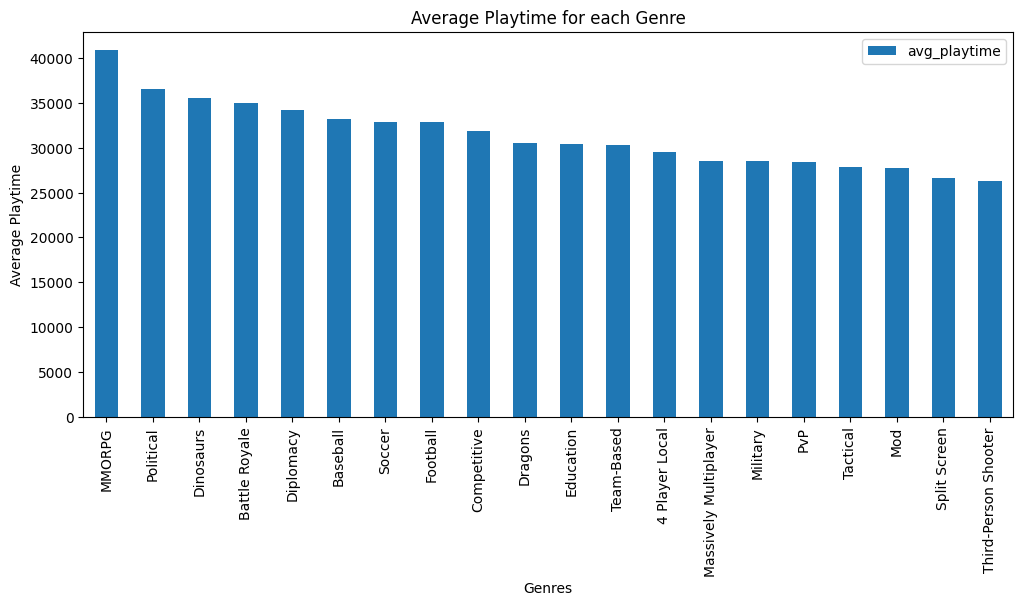

In [9]:
playtime_by_review = playerTypeByTags.select("tags", "avg_playtime").orderBy("avg_playtime", ascending=False).limit(20)
playtime_by_review.toPandas().plot.bar(x="tags",
                                        y="avg_playtime", figsize=(12, 5),
                                        title="Average Playtime for each Genre",
                                        xlabel = "Genres",
                                        ylabel = "Average Playtime")